# Creating complex meshes using mesh templates

**Author**: Maximilian Albert

**Date**: Sep 2013

**Purpose**: Illustrate the `mesh_template` functionality to build up complex meshes in Finmag.

*It should be noted that `dolfin` also comes with a CSG (Constructive Solid Geometry) module based on CGAL which serves a similar purpose. However, in 3D the mesh creation is not exactly reproducible (during different runs the meshes will have a slightly different number of vertices!), and for certain tasks it is not as convenient, which is why it is still useful to have this module in Finmag.*

Finmag provides convenience functions (such as `sphere`, `box`, `nanodisk`) in the module `finmag.util.meshes` which allow the user to quickly create meshes for frequently used shapes.

However, sometimes there is a need to create more complex meshes, for example a nanodisk with two spherical particles nearby. In order to do this, Finmag provides a more flexible mechanims using so-called *mesh templates*. These provide "blueprints" for various mesh primitives, which can be combined to form more complex meshes. It is also possible to render a mesh composed of mesh templates using different mesh discretisations.

In the following we give some examples how to create simple and more complex meshes using mesh templates.

## Mesh primitives

First we import the templates `Sphere` and `Nanodisk`, as well as the helper function `plot_mesh_with_paraview` which allows us to quickly visualise the meshes. We also set the logging level to 'INFO' in order to avoid cluttering the screen with debugging messages.

In [1]:
from finmag.util.mesh_templates import Box, Sphere, Nanodisk
from finmag.util.meshes import plot_mesh_with_paraview
import finmag
finmag.set_logging_level('INFO')

[2014-09-12 14:36:11] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2014-09-12 14:36:11] DEBUG: Building modules in 'native'...
[2014-09-12 14:36:12] DEBUG: FinMag          5435:cc1d014549dade91d815cc78f01204f53f49ffd5
[2014-09-12 14:36:12] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-09-12 14:36:12] DEBUG: Numpy           1.8.1                Scipy           0.14.0              
[2014-09-12 14:36:12] DEBUG: IPython         2.1.0                Python          2.7.6               
[2014-09-12 14:36:13] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2014-09-12 14:36:13] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2014-09-12 14:36:13] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


Next we can create a template for a spherical mesh. It accepts the usual arguments for the radius and the center of the sphere, as well as an optional `name` argument (which we do not provide here).

In [2]:
sphere = Sphere(r=20.0, center=(0, 0, 1))

We can create a mesh from this template by telling it the desired mesh discretisation:

In [3]:
mesh = sphere.create_mesh(maxh=5.0)

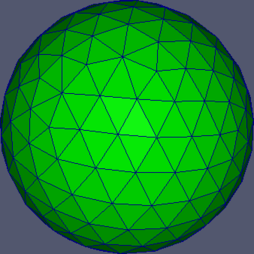

In [4]:
plot_mesh_with_paraview(mesh, rescale=0.75, use_display=0)

We can use the *exact same* template to create a spherical mesh with a coarser discretisation:

In [5]:
mesh2 = sphere.create_mesh(maxh=10.0)

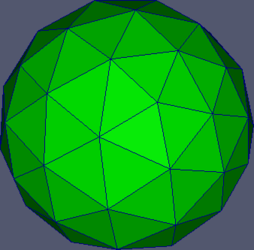

In [6]:
plot_mesh_with_paraview(mesh2, rescale=0.75, use_display=0)

So far this isn't too exciting, and we could have done all this using the simpler functions in `finmag.util.meshes`. So let's move on to building more complex meshes.

## Building more complex meshes by combining primitives

Let's create three templates: one nanodisk and two spherical particles next to it. Here we provide the `name` arguments because they will be usefule below.

In [7]:
nanodisk = Nanodisk(d=60, h=5, center=(0, 0, 0), valign='bottom', name='nanodisk')
sphere1 = Sphere(r=10, center=(-20, 0, 20), name='sphere1')
sphere2 = Sphere(r=5, center=(+15, 0, 15), name='sphere2')

We can build a template for a mesh which combines all three of these primitives by simply "adding" them together.

In [8]:
disk_with_particles = nanodisk + sphere1 + sphere2

Then we can then "render" this template to create a mesh (exactly as we did above) by providing the mesh discretisation parameter `maxh`.

In [9]:
mesh = disk_with_particles.create_mesh(maxh=5.0)

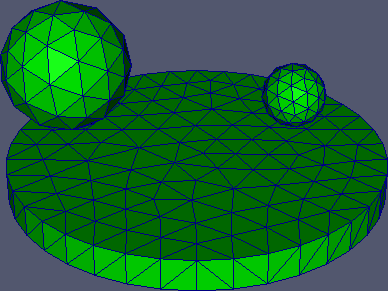

In [10]:
plot_mesh_with_paraview(mesh, camera_position=[0, -200, 100], use_display=0)

In case we'd like to use different values of `maxh` for each of the primitives, the `create_mesh()` method allows to pass in arguments of the form `maxh_NAME`, where `NAME` is the name of one of those primitives. All primitives for which no specific discretisation parameter is provided will use the "global" value of `maxh`. In the following example, we render the nanodisk with a coarser discretisation (`maxh_nanodisk=10.0`) than before and the first sphere with a finer discretisation (`maxh_sphere1=2.0`). The second sphere uses the global value `maxh=5.0` as before.

In [11]:
mesh = disk_with_particles.create_mesh(maxh=5.0, maxh_nanodisk=10.0, maxh_sphere1=2.0)

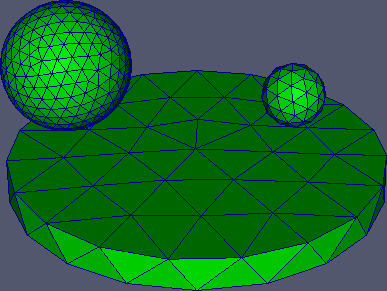

In [13]:
plot_mesh_with_paraview(mesh, camera_position=[0, -200, 100], use_display=0)

## Subtracting one mesh from another

Combining different mesh templates is useful, but in order to build more complex shapes we also need to be able to "subtract" one mesh from another. We illustrate this by building a complex shape consisting of a "trough" which contains a particle. The trough is built by starting with a box and taking away some parts belonging to a smaller box.

We begin by defining the three components.

In [14]:
box_large = Box(0, 0, 0, 100, 100, 50, name='Box_large')
box_small = Box(20, 10, 20, 80, 90, 51, name='Box_small')
sphere = Sphere(r=10, center=(50, 50, 40), name='Sphere')

Next we build the "trough" by subtracting the small box from the large one.

In [16]:
trough = box_large - box_small

Finally, we add the sphere

In [17]:
complex_shape = trough + sphere

We could also have done the previous two steps in a single line.

In [18]:
complex_shape = (box_large - box_small) + sphere

Now we can create the mesh. As an additional feature in the command below, we use different mesh discretisations for all three components. Note that we do not explicitly set `maxh_box_large`. Instead, we use the argument `maxh` which provides a default value for the mesh discretisation of all constituents for which no discretisation argument is provided explicitly. Since in our case we do explicitly provide arguments for the mesh templates `box_small` and `sphere`, the value `maxh=10.0` is only used for `box_large`.

In [19]:
mesh = complex_shape.create_mesh(maxh=10.0, maxh_Box_small=5.0, maxh_Sphere=2.0)

When plotting the resulting mesh, we can clearly see that the outer part of the trough has a rather coarse discretisation (`maxh=10.0`) which becomes less coarse towards the inside (where `maxh=5.0` is used). The sphere has the finest discretisation (`maxh=2.0`).

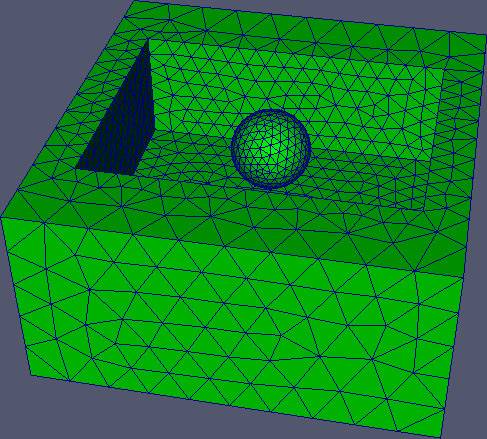

In [20]:
plot_mesh_with_paraview(mesh, camera_position=(-100, -20, 80), use_display=0)